Let $u$ be a real-valued $n$-times differentiable function of time.

You are given evaluations of this function $u(t_0), ..., u(t_n)$ at distinct points in time and asked to approximate $u^{(m)}(t)$, the $m$-th derivative of the function evaluated at some given point $t$ ($m \leq n$).

If you have studied numerical methods, you are probably already familiar with how to tackle this problem with what is sometimes referred to as the "method of undetermined coefficients" (or, in equivalent language, by using a [Lagrange interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)). In this post, after reviewing the method, we implement it in a few lines of code.

Consider approximating the derivative $u^{(m)}(t)$ by a linear combination of the observations:
\begin{equation}
\boldsymbol{w}^\intercal \boldsymbol{u}
\equiv (w_0, \ldots, w_n) (u(t_0), \ldots, u(t_n))^\intercal
= w_0 u(t_0) + \cdots + w_n u(t_n).
\end{equation}
Taylor expanding each term around *t*,
\begin{equation}
\boldsymbol{w}^\intercal \boldsymbol{u}
= \sum_{k = 0}^n w_k \left(
      u(t) +
      u^\prime(t) \left(t_k - t\right) +
      \cdots +
      u^{(n)}(t) \frac{\left(t_k - t\right)^{n}}{n!} +
      O(\left(t_k - t\right)^{n+1})
\right).
\end{equation}
Rearranging the resulting expression,
\begin{equation}
\boldsymbol{w}^\intercal \boldsymbol{u}
= O(\max_k \left|t_k - t\right|^{n+1} \Vert \boldsymbol{w} \Vert_\infty) +
\sum_{k = 0}^{n} u^{(k)}(t) \left(
      w_0 \frac{\left(t_0 - t\right)^k}{k!} +
      \cdots +
      w_n \frac{\left(t_n - t\right)^k}{k!}
\right).
\end{equation}

The form above makes it clear that the original linear combination is nothing more than an error term (represented in Big O notation) along with a weighted sum of the derivatives of $u$ evaluated at $t$. Since we are interested only in the $m$-th derivative, we would like to pick the weights $\boldsymbol{w}$ such that the coefficient of $u^{(k)}(t)$ is 1 whenever $k=m$ and 0 otherwise. This suggests solving the linear system

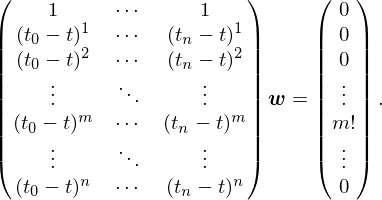

The matrix on the left hand side is a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix), and hence this system has a unique solution. Denoting by $\boldsymbol{v}$ the solution of this system, we have
\begin{equation}
    u^{(m)}(t) = \boldsymbol{v}^\intercal \boldsymbol{u} + O(\max_k \left|t_k - t\right|^{n+1} \Vert \boldsymbol{v} \Vert_\infty).
\end{equation}

## Example application: backward differentiation formula (BDF)

As an application, consider the case in which we want to compute the first derivative of the function ($m=1$) and the observations are made at the points $t_k=t-kh$ where $h$ is some positive constant. In this case, the linear system simplifies significantly:

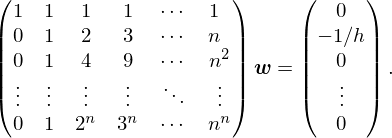

Code to solve this linear system for a fixed value of *n* is given below.

In [2]:
%load_ext lab_black

In [23]:
import numpy as np


def bdf(n):
    """Creates the coefficient vector for a BDF formula of order `n`.

    Parameters
    ----------
    n: A positive integer.

    Returns
    -------
    A (one-dimensional) numpy array of coefficients `hw`.
    Denoting by `h` a positive step size, the derivative is approximated by
    `(hw[0] * u(t) + hw[1] * u(t-h) + ... + hw[n] * u(t-nh)) / h`
    where u is some real-valued, real-input callable.
    """
    A = np.vander(range(n + 1), increasing=True).transpose()
    b = [(1 - 2 * (k % 2)) * int(k == 1) for k in range(n + 1)]
    return np.linalg.solve(A, b)

Here are the results of running this code with different values of $n$:

In [28]:
from fractions import Fraction

from tabulate import tabulate


n = 5
rows = []
for n in range(1, n + 1):
    row = [f"$n={n}$"] + [str(Fraction(x).limit_denominator()) for x in bdf(n)]
    rows.append(row)
tabulate(rows, headers=[""] + [f"$hw_{n}$" for n in range(n + 1)], tablefmt="html")

'<table>\n<thead>\n<tr><th>     </th><th>$hw_0$  </th><th style="text-align: right;">  $hw_1$</th><th>$hw_2$  </th><th>$hw_3$  </th><th>$hw_4$  </th><th>$hw_5$  </th></tr>\n</thead>\n<tbody>\n<tr><td>$n=1$</td><td>1       </td><td style="text-align: right;">      -1</td><td>        </td><td>        </td><td>        </td><td>        </td></tr>\n<tr><td>$n=2$</td><td>3/2     </td><td style="text-align: right;">      -2</td><td>1/2     </td><td>        </td><td>        </td><td>        </td></tr>\n<tr><td>$n=3$</td><td>11/6    </td><td style="text-align: right;">      -3</td><td>3/2     </td><td>-1/3    </td><td>        </td><td>        </td></tr>\n<tr><td>$n=4$</td><td>25/12   </td><td style="text-align: right;">      -4</td><td>3       </td><td>-4/3    </td><td>1/4     </td><td>        </td></tr>\n<tr><td>$n=5$</td><td>137/60  </td><td style="text-align: right;">      -5</td><td>5       </td><td>-10/3   </td><td>5/4     </td><td>-1/5    </td></tr>\n</tbody>\n</table>'

As an example of how to read the above table, the third row ($n=3$) tells us
\begin{equation}
h u^\prime(t) = 11/6 \cdot u(t) - 3 \cdot u(t - h) + 3/2 \cdot u(t - 2h) - 1/3 \cdot u(t - 3h) + O(h^4).
\end{equation}

As a crude sanity check, we can verify that the *n*-th BDF formula applied to $e^x$ becomes a better approximation of $e^x$ as *n* increases (recall that the exponential function is its own derivative):

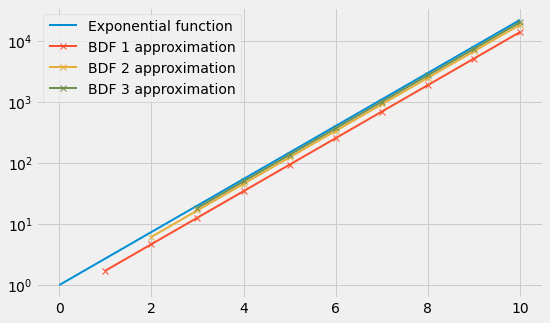

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


mpl.style.use("fivethirtyeight")
mpl.rcParams["lines.linewidth"] = 2

a = 0.0
b = 10.0
N = 10
h = (b - a) / N
x = np.linspace(a, b, N + 1)
y = np.exp(x)

plt.figure(figsize=(1.618 * 5.0, 5.0))
plt.semilogy(x, y, label="Exponential function")
for n in range(1, 4):
    approx_exp = (np.convolve(bdf(n), y) / h)[n:-n]
    plt.semilogy(x[n:], approx_exp, "-x", label="BDF {} approximation".format(n))

plt.legend()
plt.show()